In [1]:
# Upgrade pip if needed
!pip install --upgrade pip

# Core libraries for the project
!pip install diffusers transformers accelerate safetensors torch torchvision

# For LoRA support (style modules)
!pip install peft

# For image-text similarity scoring (CLIP)
!pip install open_clip_torch sentence-transformers

# For image captioning (BLIP)
!pip install git+https://github.com/salesforce/BLIP

# (Optional) For UI demo
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.6 MB/s eta 0:00:00
  Cloning https://github.com/salesforce/BLIP to /tmp/pip-req-build-wgiqpg2l
  Running command git clone --filter=blob:none --quiet https://github.com/salesforce/BLIP /tmp/pip-req-build-wgiqpg2l
  Resolved https://github.com/salesforce/BLIP to commit 3a29b7410476bf5f2ba0955827390eb6ea1f4f9d
ERROR: git+https://github.com/salesforce/BLIP does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 119.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 127.3 MB/s eta 0:00:00


In [2]:
import json

with open("/kaggle/input/coco-subset/coco_data/annotations/filtered_captions_5k.json", "r") as f:
    data = json.load(f)
    filtered_annotations = data["annotations"]

📋 Sample Captions + Images:


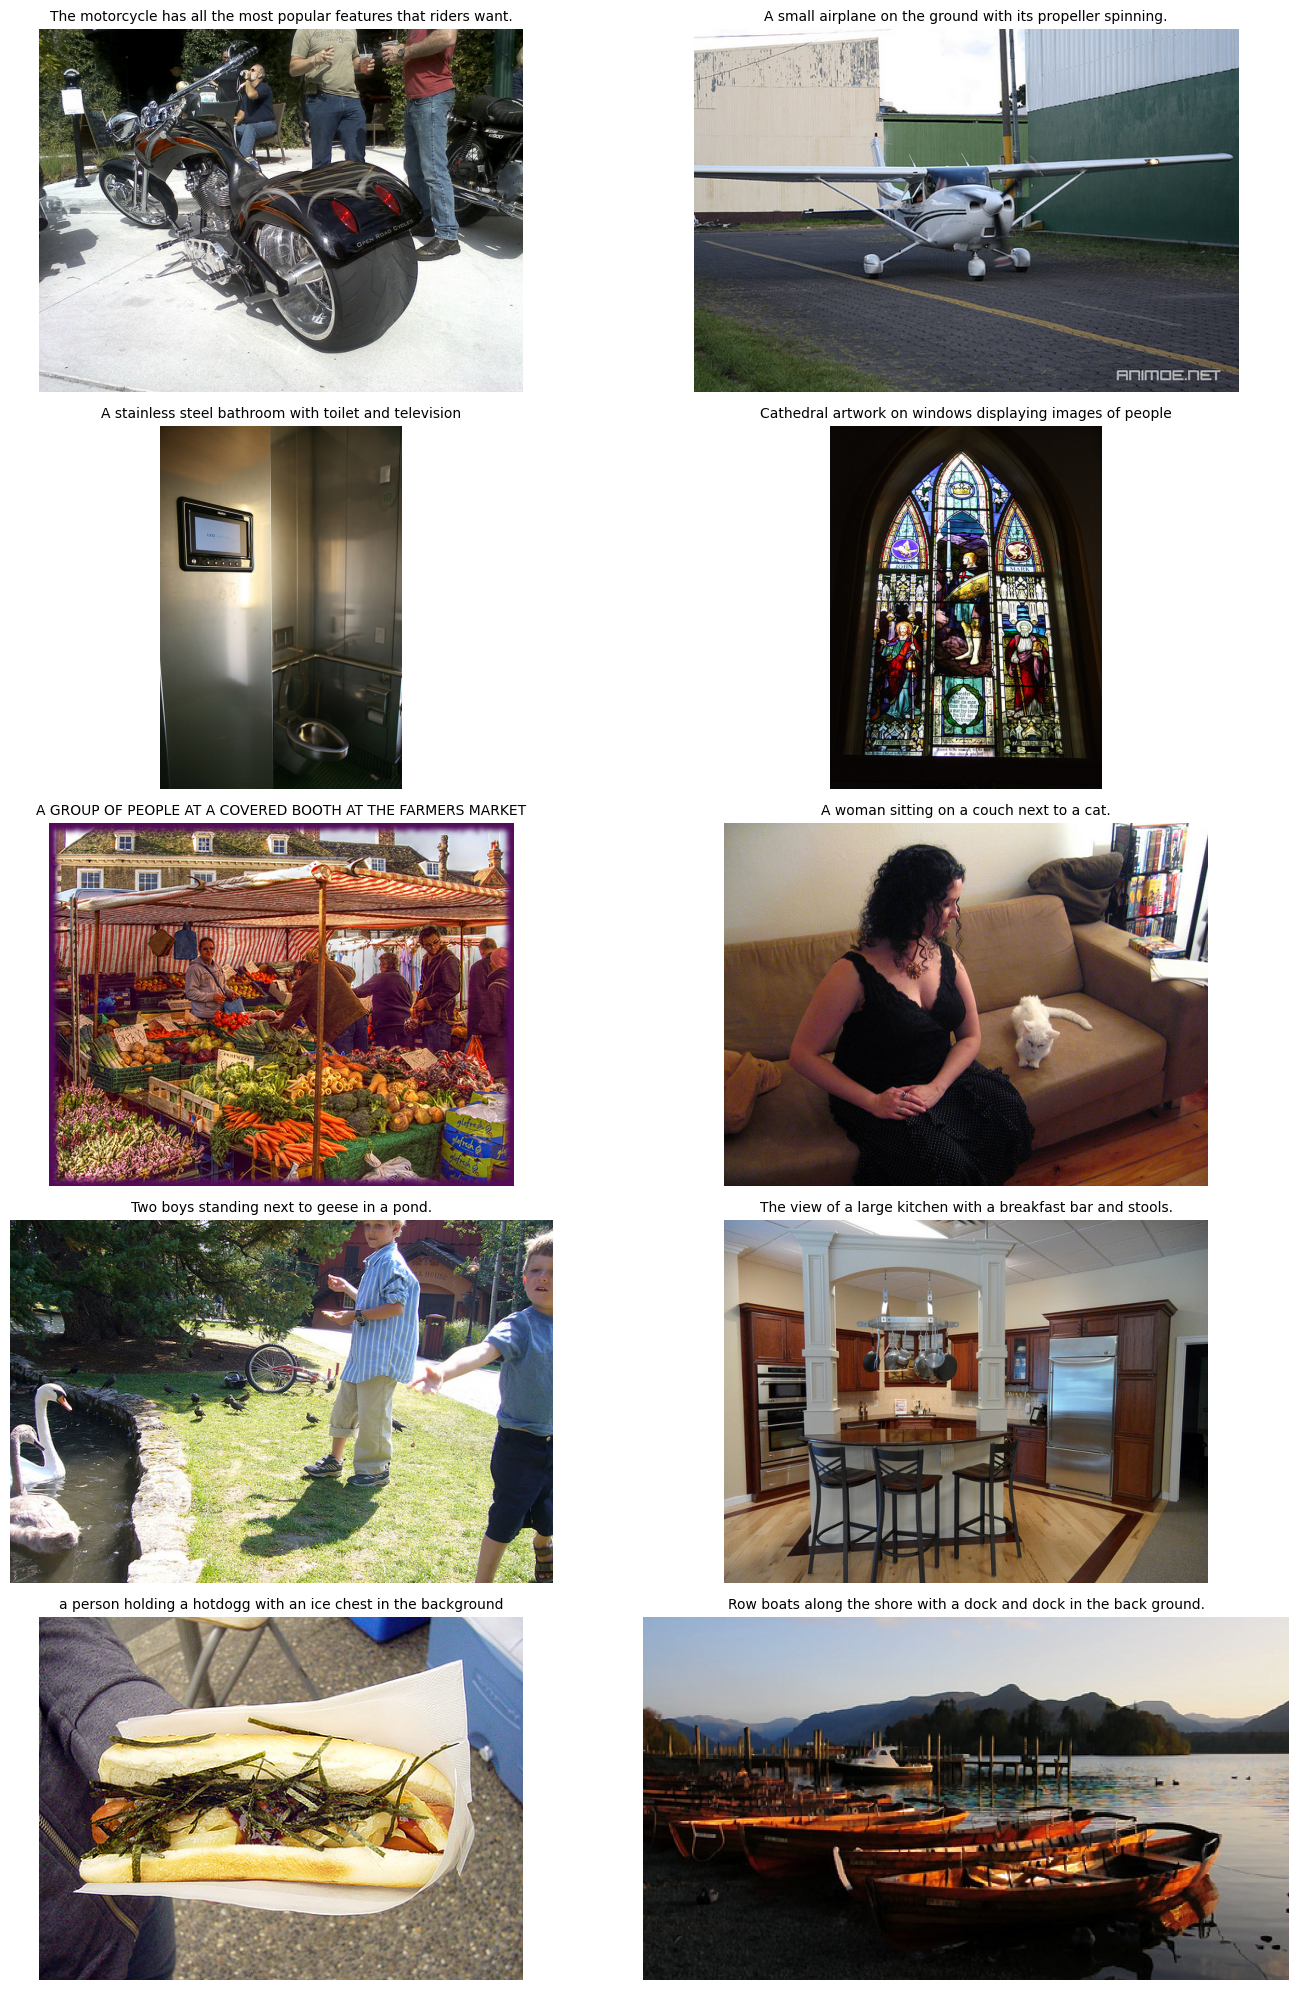

In [3]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_dir = "/kaggle/input/coco-subset/coco_data/train2017_subset"

samples = random.sample(filtered_annotations, 10)

print("📋 Sample Captions + Images:")

plt.figure(figsize=(15, 20))
for i, ann in enumerate(samples):
    image_id = ann['image_id']
    caption = ann['caption']
    filename = f"{image_id:012d}.jpg"
    image_path = os.path.join(image_dir, filename)

    plt.subplot(5, 2, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=10)

plt.tight_layout()
plt.show()

Implement prompt enhancer

In [4]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load pretrained T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to("cuda")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
def enhance_caption(caption, max_length=40):
    prompt = f"Elaborate this caption: {caption}"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=max_length)
    enhanced = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return enhanced

In [6]:
# Get 200 sample captions
sample_captions = [ann['caption'] for ann in filtered_annotations[:200]]

# Enhance each caption
enhanced_pairs = []
for cap in sample_captions:
    rich = enhance_caption(cap)
    enhanced_pairs.append((cap, rich))

In [12]:
import random

print("🎨 Prompt Enhancement Examples:\n")
for orig, enhanced in random.sample(enhanced_pairs, 10):
    print(f"📝 Original: {orig}")
    print(f"✨ Enhanced: {enhanced}")
    print("-" * 60)

🎨 Prompt Enhancement Examples:

📝 Original: Adults with childern walking in the rain with umbrellas.
✨ Enhanced: Children are walking in the rain with umbrellas.
------------------------------------------------------------
📝 Original: A jetliner parked on an airport tarmac next to a passenger loading terminal.
✨ Enhanced: A jetliner parked on an airport tarmac next to a passenger loading terminal.
------------------------------------------------------------
📝 Original: An airplane with the landing gear down flying in clear skies.
✨ Enhanced: A plane with the landing gear down flying in clear skies.
------------------------------------------------------------
📝 Original: A white toilet in a public washroom that looks very clean.
✨ Enhanced: A toilet in a public washroom that looks very clean.
------------------------------------------------------------
📝 Original: A cat sitting on a desk next to a window.
✨ Enhanced: A cat is sitting on a desk next to a window.
-------------------------

Filter Dangerous Prompts

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("martin-ha/toxic-comment-model")
model = AutoModelForSequenceClassification.from_pretrained("martin-ha/toxic-comment-model").to("cuda")

tokenizer_config.json:   0%|          | 0.00/403 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
TOXIC_LABELS = ["toxic", "severe toxic", "obscene", "threat", "insult", "identity hate"]

def check_prompt_safety(prompt, threshold=0.3):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits)[0].cpu().numpy()

    flagged = {label: float(prob) for label, prob in zip(TOXIC_LABELS, probs) if prob > threshold}

    print(f"🧪 Prompt: {prompt}")
    for label, prob in zip(TOXIC_LABELS, probs):
        print(f"{label.capitalize():>15}: {prob:.3f}")

    if flagged:
        print("❌ Blocked due to:", list(flagged.keys()))
        return False
    return True

In [15]:
prompt = "Man in bikini."

is_safe = check_prompt_safety(prompt)

🧪 Prompt: Man in bikini.
          Toxic: 0.859
   Severe toxic: 0.100
❌ Blocked due to: ['toxic']


Image generation pipeline

In [16]:
!pip install diffusers transformers accelerate safetensors

In [ ]:
from huggingface_hub import login

login(" ")

In [18]:
from diffusers import StableDiffusionXLPipeline
import torch

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")

# Enable fast inference
pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()  # Helps with large images on small GPUs

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


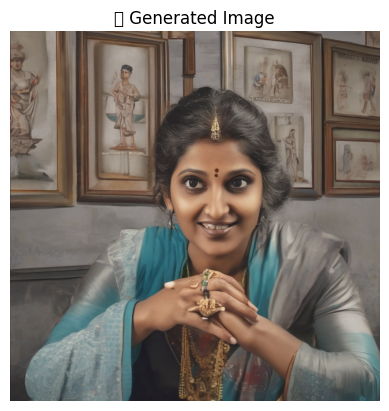

In [19]:
import matplotlib.pyplot as plt

prompt = "stupid sarayu"
image = pipe(prompt).images[0]

plt.imshow(image)
plt.axis("off")
plt.title("🖼️ Generated Image")
plt.show()

Style control with LoRA models

In [20]:
!pip install diffusers transformers accelerate peft safetensors

In [42]:
import warnings
warnings.filterwarnings("ignore", message=".*missing keys in the model.*")


In [38]:
# Apply LoRA style
def apply_style(style="none"):
    if style == "cyberpunk":
        pipe.load_lora_weights(
            "issaccyj/lora-sdxl-cyberpunk",
            weight_name="pytorch_lora_weights.safetensors"
        )
        print("🎯 Applied: Cyberpunk style")

    elif style == "anime":
        pipe.load_lora_weights(
            "Linaqruf/pastel-anime-xl-lora",
            weight_name="pastel-anime-xl.safetensors"
        )
        print("🎯 Applied: Anime style")

    elif style == "none":
        print("✅ Using default SDXL (no LoRA applied)")
        # Don't call load_lora_weights here

    else:
        print("⚠️ Unknown style. Using default SDXL")

# Generate image with a given style
def generate_with_style(style_name, prompt):
    apply_style(style_name)
    image = pipe(prompt).images[0]
    return image

# Generate for each style
styles = ["none", "cyberpunk", "anime"]
style_outputs = {}

enhanced_prompt = enhanced_pairs[0][1]  # take the first enhanced caption

# Then run your multi-style generation:
for style in styles:
    print(f"🎨 Generating with style: {style}")
    style_outputs[style] = generate_with_style(style, enhanced_prompt)


🎨 Generating with style: none
✅ Using default SDXL (no LoRA applied)


  0%|          | 0/50 [00:00<?, ?it/s]

🎨 Generating with style: cyberpunk


pytorch_lora_weights.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

🎯 Applied: Cyberpunk style


  0%|          | 0/50 [00:00<?, ?it/s]

🎨 Generating with style: anime


pastel-anime-xl.safetensors:   0%|          | 0.00/197M [00:00<?, ?B/s]

🎯 Applied: Anime style


  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
def generate_with_style(style_name, prompt):
    # Apply style
    if style_name == "cyberpunk":
        pipe.load_lora_weights("issaccyj/lora-sdxl-cyberpunk", weight_name="pytorch_lora_weights.safetensors")
    elif style_name == "anime":
        pipe.load_lora_weights("Linaqruf/pastel-anime-xl-lora", weight_name="pastel-anime-xl.safetensors")
    elif style_name == "none":
        pass  # Default SDXL
    else:
        raise ValueError("Unknown style")

    # Generate image
    image = pipe(prompt).images[0]
    return image

In [23]:
styles = ["none", "cyberpunk", "anime"]
style_outputs = {}

for style in styles:
    print(f"🎨 Generating with style: {style}")
    style_outputs[style] = generate_with_style(style, enhanced_prompt)

🎨 Generating with style: none


NameError: name 'enhanced_prompt' is not defined

In [30]:
# Enhancement model
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to("cuda")

def enhance_caption(caption, max_length=40):
    prompt = f"Elaborate this caption: {caption}"
    inputs = t5_tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = t5_model.generate(**inputs, max_new_tokens=max_length)
    enhanced = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return enhanced

In [36]:
tox_tokenizer = AutoTokenizer.from_pretrained("martin-ha/toxic-comment-model")
tox_model = AutoModelForSequenceClassification.from_pretrained("martin-ha/toxic-comment-model").to("cuda")

def check_prompt_safety(prompt, threshold=0.9):  # previously 0.3
    inputs = tox_tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        outputs = tox_model(**inputs)
        probs = torch.sigmoid(outputs.logits)[0].cpu().numpy()

    flagged = {label: float(prob) for label, prob in zip(TOXIC_LABELS, probs) if prob > threshold}

    print(f"🧪 Prompt: {prompt}")
    for label, prob in zip(TOXIC_LABELS, probs):
        print(f"{label.capitalize():>15}: {prob:.3f}")

    if flagged:
        print("❌ Blocked due to:", list(flagged.keys()))
        return False
    return True

In [26]:
# Load SDXL base model (ensure it's loaded only once)
from diffusers import StableDiffusionXLPipeline
import torch

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")

pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
def full_generation_pipeline(raw_caption, styles=["none", "cyberpunk", "anime"]):
    print("\n📝 Original Caption:", raw_caption)

    # 1. Enhance the prompt
    enhanced_prompt = enhance_caption(raw_caption)
    print("✨ Enhanced Prompt:", enhanced_prompt)

    # 2. Check prompt safety
    if not check_prompt_safety(enhanced_prompt):
        print("⚠️ Aborting generation due to unsafe prompt.")
        return None

    # 3. Generate image in each style
    results = {}
    for style in styles:
        print(f"\n🎨 Generating with style: {style}")
        apply_style(style)
        image = pipe(enhanced_prompt).images[0]
        results[style] = image

    return {
        "caption": raw_caption,
        "enhanced": enhanced_prompt,
        "images": results
    }

In [28]:
import matplotlib.pyplot as plt

def display_generated_images(result_dict):
    images = result_dict["images"]
    styles = list(images.keys())

    plt.figure(figsize=(15, 5))
    for i, style in enumerate(styles):
        plt.subplot(1, len(styles), i + 1)
        plt.imshow(images[style])
        plt.axis("off")
        plt.title(style.capitalize())

    plt.suptitle("🖼️ Style Comparison", fontsize=16)
    plt.show()


📝 Original Caption: A man is sitting on a bench next to a bike.
✨ Enhanced Prompt: A man is riding a bike.
🧪 Prompt: A man is riding a bike.
          Toxic: 0.894
   Severe toxic: 0.075

🎨 Generating with style: none
✅ Using default SDXL (no LoRA applied)


  0%|          | 0/50 [00:00<?, ?it/s]


🎨 Generating with style: cyberpunk


Loading adapter weights from state_dict led to missing keys in the model: down_blocks.0.resnets.0.conv1.lora_A.default_1.weight, down_blocks.0.resnets.0.conv1.lora_B.default_1.weight, down_blocks.0.resnets.0.time_emb_proj.lora_A.default_1.weight, down_blocks.0.resnets.0.time_emb_proj.lora_B.default_1.weight, down_blocks.0.resnets.0.conv2.lora_A.default_1.weight, down_blocks.0.resnets.0.conv2.lora_B.default_1.weight, down_blocks.0.resnets.1.conv1.lora_A.default_1.weight, down_blocks.0.resnets.1.conv1.lora_B.default_1.weight, down_blocks.0.resnets.1.time_emb_proj.lora_A.default_1.weight, down_blocks.0.resnets.1.time_emb_proj.lora_B.default_1.weight, down_blocks.0.resnets.1.conv2.lora_A.default_1.weight, down_blocks.0.resnets.1.conv2.lora_B.default_1.weight, down_blocks.0.downsamplers.0.conv.lora_A.default_1.weight, down_blocks.0.downsamplers.0.conv.lora_B.default_1.weight, down_blocks.1.attentions.0.proj_in.lora_A.default_1.weight, down_blocks.1.attentions.0.proj_in.lora_B.default_1.weig

🎯 Applied: Cyberpunk style


  0%|          | 0/50 [00:00<?, ?it/s]


🎨 Generating with style: anime
🎯 Applied: Anime style


  0%|          | 0/50 [00:00<?, ?it/s]

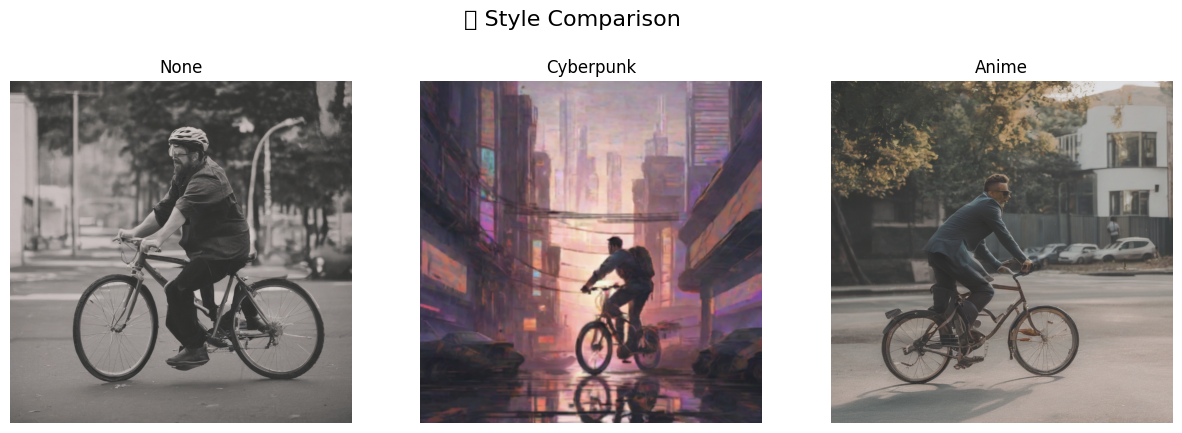

In [39]:
# Pick a random caption from your enhanced_pairs or raw set
raw_caption = sample_captions[0]  # or any string like "A dog running through snow"

result = full_generation_pipeline(raw_caption)
if result:
    display_generated_images(result)

In [40]:
import open_clip
import torchvision.transforms as T
from PIL import Image
import torch

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='openai'
)
clip_model = clip_model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [44]:
def get_clip_score(image, prompt):
    # Preprocess
    image_input = clip_preprocess(image).unsqueeze(0).to(device)
    text_input = tokenizer([prompt]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ text_features.T).item()

    return similarity  # higher = better match

In [45]:
clip_scores = {}

for style, img in style_outputs.items():
    score = get_clip_score(img, enhanced_prompt)
    clip_scores[style] = score
    print(f"🔍 CLIP score for '{style}': {score:.4f}")

🔍 CLIP score for 'none': 0.2765
🔍 CLIP score for 'cyberpunk': 0.2912
🔍 CLIP score for 'anime': 0.2770


In [48]:
!pip install git+https://github.com/salesforce/BLIP


  Cloning https://github.com/salesforce/BLIP to /tmp/pip-req-build-r9_haagh
  Running command git clone --filter=blob:none --quiet https://github.com/salesforce/BLIP /tmp/pip-req-build-r9_haagh
  Resolved https://github.com/salesforce/BLIP to commit 3a29b7410476bf5f2ba0955827390eb6ea1f4f9d
ERROR: git+https://github.com/salesforce/BLIP does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [49]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [50]:
def generate_blip_caption(image):
    inputs = blip_processor(image, return_tensors="pt").to("cuda")
    output = blip_model.generate(**inputs, max_new_tokens=30)
    caption = blip_processor.decode(output[0], skip_special_tokens=True)
    return caption


In [51]:
!pip install evaluate


In [53]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2b2f0317c6acf6300dfc6c1e83f38d72d54a96aecaf6fbe0b4d78926852b75f1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [54]:
import evaluate

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")


In [55]:
def evaluate_caption_metrics(prompt, caption):
    bleu_score = bleu.compute(predictions=[caption], references=[prompt])
    rouge_score = rouge.compute(predictions=[caption], references=[prompt])
    return bleu_score["bleu"], rouge_score["rougeL"]


In [56]:
# Example original prompt and BLIP-generated caption
enhanced_prompt = "A man is sitting on a bench next to a bike in a quiet city park."
blip_caption = "A man sitting on a bench beside his bicycle in a park."

# Run evaluation
bleu_score, rouge_score = evaluate_caption_metrics(enhanced_prompt, blip_caption)

# Print results
print(f"📊 BLEU Score: {bleu_score:.4f}")
print(f"📊 ROUGE-L Score: {rouge_score:.4f}")


📊 BLEU Score: 0.2126
📊 ROUGE-L Score: 0.6429


In [57]:
# Example: get the cyberpunk image (already in memory)
final_image = style_outputs["cyberpunk"]  # or "none", "anime"

# Show the image (optional)
final_image.show()

# Get the caption
caption = generate_blip_caption(final_image)
print("🖼️ BLIP Caption:", caption)

🖼️ BLIP Caption: a man riding a bike through a city


In [58]:
import os
import json
import random
from PIL import Image
from tqdm import tqdm
import torch
import open_clip
import torchvision.transforms as T

In [59]:
image_dir = "/kaggle/input/coco-subset/coco_data/train2017_subset"
annotations_path = "/kaggle/input/coco-subset/coco_data/annotations/filtered_captions_5k.json"

In [60]:
with open(annotations_path, "r") as f:
    coco_data = json.load(f)

filtered_annotations = coco_data["annotations"]


In [61]:
def get_clip_text_score(image, prompt):
    image_input = clip_preprocess(image).unsqueeze(0).to(device)
    text_input = clip_tokenizer([prompt]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return (image_features @ text_features.T).item()

def get_clip_image_to_image_score(img1, img2):
    img1_input = clip_preprocess(img1).unsqueeze(0).to(device)
    img2_input = clip_preprocess(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        f1 = clip_model.encode_image(img1_input)
        f2 = clip_model.encode_image(img2_input)
        f1 /= f1.norm(dim=-1, keepdim=True)
        f2 /= f2.norm(dim=-1, keepdim=True)
        return (f1 @ f2.T).item()


In [62]:
sampled_annotations = random.sample(filtered_annotations, 50)
results = []

for ann in tqdm(sampled_annotations):
    img_id = ann["image_id"]
    prompt = ann["caption"]
    img_path = os.path.join(image_dir, f"{img_id:012d}.jpg")

    if not os.path.exists(img_path):
        continue

    real_image = Image.open(img_path).convert("RGB")

    results.append({
        "image_id": img_id,
        "prompt": prompt,
        "real_image": real_image
    })


100%|██████████| 50/50 [00:00<00:00, 51.13it/s]


In [ ]:
import torch
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    AutoTokenizer, AutoModelForSequenceClassification,
    BlipProcessor, BlipForConditionalGeneration
)
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from peft import PeftModel
from PIL import Image
import numpy as np
from open_clip import create_model_and_transforms, tokenize
from sentence_transformers import util

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load all models
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to(device)

tox_tokenizer = AutoTokenizer.from_pretrained("martin-ha/toxic-comment-model")
tox_model = AutoModelForSequenceClassification.from_pretrained("martin-ha/toxic-comment-model").to(device)

clip_model, _, clip_preprocess = create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model = clip_model.to(device)

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# ✅ UPDATED: Use SDXL
from diffusers import StableDiffusionXLPipeline

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Prompt enhancement
def enhance_prompt_t5(prompt):
    input_text = f"Elaborate this caption: {prompt}"
    inputs = t5_tokenizer(input_text, return_tensors="pt").to(device)
    outputs = t5_model.generate(**inputs, max_new_tokens=40)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

# Prompt safety
banned_keywords = [
    "kill", "attack", "shoot", "dead", "blood", "murder", "weapon",
    "nude", "naked", "sex", "drugs", "violence", "abuse", "hate",
    "terror", "racist", "bomb", "gun", "suicide", "injury", "harass"
]

def is_prompt_safe(prompt, banned_words=banned_keywords):
    prompt_lower = prompt.lower()
    matched = [word for word in banned_words if word in prompt_lower]
    if matched:
        print(f"❌ Blocked due to: {matched}")
        return False
    print("✅ Safe prompt.")
    return True

# ✅ Style support for SDXL
def apply_style(style="none"):
    if style == "cyberpunk":
        pipe.load_lora_weights(
            "issaccyj/lora-sdxl-cyberpunk",
            weight_name="pytorch_lora_weights.safetensors"
        )
        pipe.to(device)
        print("🎯 Applied: Cyberpunk style")

    elif style == "anime":
        pipe.load_lora_weights(
            "Linaqruf/pastel-anime-xl-lora",
            weight_name="pastel-anime-xl.safetensors"
        )
        pipe.to(device)
        print("🎯 Applied: Anime style")

    elif style == "none":
        print("✅ Using default SDXL (no LoRA applied)")

    else:
        print("⚠ Unknown style. Using default SDXL")

# Image generation
def generate_image_with_style(prompt, style="none"):
    apply_style(style)
    image = pipe(prompt=prompt, negative_prompt="ugly, blurry").images[0]
    return image

def generate_images(prompt, num_images=3):
    return [pipe(prompt=prompt, negative_prompt="ugly, blurry").images[0] for _ in range(num_images)]

# CLIP scoring
def score_with_clip(prompt, images):
    tokenized = tokenize([prompt]).to(device)
    image_tensors = torch.stack([clip_preprocess(img).to(device) for img in images])
    with torch.no_grad():
        image_features = clip_model.encode_image(image_tensors)
        text_features = clip_model.encode_text(tokenized)
    sims = util.cos_sim(image_features, text_features).squeeze()
    best_idx = torch.argmax(sims).item()
    return images[best_idx]

# Captioning with BLIP
def generate_caption_blip(image):
    inputs = blip_processor(images=image, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs)
    return blip_processor.decode(out[0], skip_special_tokens=True)

# Run the full pipeline
def run_pipeline(user_prompt, style="none"):
    enhanced = enhance_prompt_t5(user_prompt)
    if not is_prompt_safe(enhanced):
        return None, None, "⚠ Unsafe prompt. Please rephrase."

    image = generate_image_with_style(enhanced, style)
    caption = generate_caption_blip(image)
    return image, caption, None

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/403 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create prompt input box
prompt_box = widgets.Text(
    value='A dog playing in the park',
    placeholder='Enter your prompt here...',
    description='Prompt:',
    layout=widgets.Layout(width='100%')
)

# Style selector dropdown
style_dropdown = widgets.Dropdown(
    options=['none', 'cyberpunk', 'anime'],
    value='none',
    description='Style:'
)

# Button to trigger generation
generate_btn = widgets.Button(description="Generate Image", button_style='success')
output = widgets.Output()

# Define the generation logic
def on_generate_click(b):
    with output:
        clear_output()
        prompt = prompt_box.value
        style = style_dropdown.value
        print(f"🔍 Original Prompt: {prompt}")
        print(f"🎨 Style: {style}")
        
        # Run the pipeline
        image, caption, error = run_pipeline(prompt, style)
        if error:
            print(error)
        else:
            display(image)
            print("📝 Generated Caption:", caption)

# Bind button click
generate_btn.on_click(on_generate_click)

# Show the UI
display(prompt_box, style_dropdown, generate_btn, output)

Text(value='A dog playing in the park', description='Prompt:', layout=Layout(width='100%'), placeholder='Enter…

Dropdown(description='Style:', options=('none', 'cyberpunk', 'anime'), value='none')

Button(button_style='success', description='Generate Image', style=ButtonStyle())

Output()